# `Applied Machine Learning`

### Approved by Donat Balaj (dbalaj@constructor.university)

## `Lab 5. SVM, Logistic Regression, Features Selection`

#### *The rules and guidelines can be found at the Rules section at the end of the LAB.



### About the task

In this lab you will:
- set up support vector machines, visualize support vectors.
- become familiar with calibration curves and compare the probabilities produced by logistic regression and support vector machines.
- study methods of working with categorical variables

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, log_loss, precision_score, recall_score

import seaborn as sns
import matplotlib_inline
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline
np.random.seed(42)

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## `Part 1. SVM and Probability calibration`

Let's generate synthetic data:

In [2]:
X, y = make_classification(n_samples=100000, n_features=20, n_informative=10, n_redundant=10, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<font color='brown'>**Exercise 1.** Train the SVM. The usual option corresponds to the linear core (LinearSVC/LinearSVR in the scikit-learn library) and the 'hinge' loss.</font>

In [3]:
### your code here
from sklearn.svm import LinearSVC
model1 = LinearSVC(loss='hinge',random_state=42)
model1.fit(X_train, y_train)

LinearSVC(loss='hinge', random_state=42)

<font color='brown'>**Exercise 2.** Compute ROC-AUC on the test part of data:</font>

In [4]:
### your code here

score =roc_auc_score(y_test, model1.decision_function(X_test))
score

0.9256586606715822

In [5]:
assert score > 0.92

<font color='brown'>**Exercise 3.** Draw ROC curve on the same data split:</font>

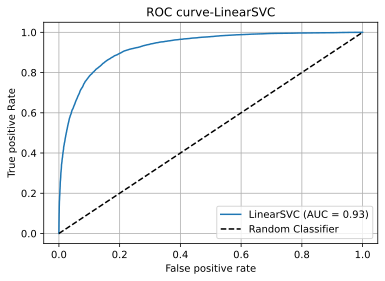

In [6]:
### your code here
fpr, tpr, thresholds = roc_curve(y_test, model1.decision_function(X_test))
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"LinearSVC (AUC = {score:.2f})")
plt.plot([0,1], [0,1], 'k--', label="Random Classifier")
plt.xlabel("False positive rate")
plt.ylabel("True positive Rate")
plt.title("ROC curve-LinearSVC")
plt.legend()
plt.grid(True)
plt.show()

In the name of the method there are some "support vectors". Let's analyze them

<font color='brown'>**Exercise 4.** Generate a synthetic dataset using make_classical with $2$ features (at least $100$ objects, but preferably more):</font>

In [7]:
### your code here

X_sint, y_sint = make_classification(n_samples=200, n_features=2,n_informative=2, n_redundant=0,n_clusters_per_class=1, random_state=42)

<font color='brown'>**Exercise 5.** Train the SVM on this data. This time, instead of LinearSVC, use the SVC with the linear core (`kernel = 'linear'`), since only it contains information about support vectors:</font>

In [8]:
### your code here
model = SVC(kernel='linear',random_state=42)
model.fit(X_sint,y_sint)

SVC(kernel='linear', random_state=42)


<font color='brown'>**Exercise 6.** Visualize the separating line, all objects and highlight the support vectors (`support_vectors` attribute):</font>

![SVM](https://www.researchgate.net/publication/304611323/figure/fig8/AS:668377215406089@1536364954428/Classification-of-data-by-support-vector-machine-SVM.png)

In [9]:
### your code here

# First: define separating line
xx = np.linspace(X_sint[:,0].min()-1,X_sint[:,0].max() + 1)

yy = -(model.coef_[0][0]*xx +model.intercept_[0])/ model.coef_[0][1]

# Second: define margin lines. They are parallel to the separating line but shifted on some margin. See image above
margin = 1 / np.sqrt(np.sum(model.coef_[0] ** 2)) # Distance between margin lines
yy_down = yy - np.sqrt(1 + (model.coef_[0][0] / model.coef_[0][1]) **2) * margin # Bottom margin line
yy_up = yy + np.sqrt(1 + (model.coef_[0][0] / model.coef_[0][1]) **2) * margin # Top margin line

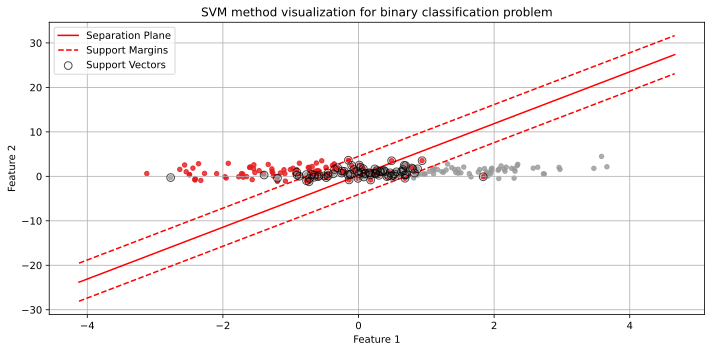

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.scatter(x=X_sint[:, 0], y=X_sint[:, 1], c=y_sint, cmap='Set1', s=20, alpha=0.8)

ax.plot(xx, yy, 'r-', label='Separation Plane')
ax.plot(xx, yy_down, 'r--', label='Support Margins')
ax.plot(xx, yy_up, 'r--')

ax.scatter(
    model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=60, facecolors='none', alpha=0.7, zorder=10, edgecolors='black', label='Support Vectors',
)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('SVM method visualization for binary classification problem')

ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

Let's move on to the assessment of the quality of probabilities that algorithms predict. Let's start with calibration curves.

Suppose the algorithm returns some numbers from zero to one. Does it evaluate the probability? To do this, we divide the segment $[0, 1]$ into several small segments of the same length. Consider the $i$-th segment with boundaries $[a_i, b_i]$ and the predictions $p_1, p_2, \dots, p_k$ that fell into it. Let them correspond to the true answers $y_1, y_2, \dots, y_k$. If the algorithm produces correct probabilities, then among these true answers there should be approximately $(a_i + b_i) / 2$ ones. In other words, if you draw a curve in which the centers of the segments are plotted along the $X$ axis, and the shares of individual responses of these segments are plotted along the $Y$ axis, then it should turn out to be diagonal.

<font color='brown'>**Exercise 7.** Below is a function that should draw such curves. There are two mistakes in it — find and correct them.</font>

In [11]:
def plot_calibration_curve(y_test, preds, model_name, n_bins=20, show=True):
    bin_middle_points, bin_real_ratios = [], []
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l+r)/2)##first mistake 1-r gives a negative value
        bin_real_ratios.append((y_test[(preds>= l)&(preds<r)]== 1).mean())##second mistake 

    if show:
        fig, ax = plt.subplots(1, 1, figsize=(6, 3))
        ax.plot(bin_middle_points, bin_real_ratios)
        ax.set_xlabel('estimated probability')
        ax.set_ylabel('positive labels share')
        ax.set_title('Calibration curve of {}'.format(model_name))
        ax.grid(True)

        fig.tight_layout()
        plt.show()

    return bin_middle_points, bin_real_ratios

In [12]:
gen = np.random.default_rng(seed=42)
bin_middle_points, bin_real_ratios = plot_calibration_curve(
    gen.binomial(1, 0.5, size=1000), gen.uniform(0.0, 1.0, size=1000), '', show=False
)

bin_middle_points_true = [
    0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325,
    0.375, 0.425, 0.475, 0.525, 0.575, 0.625, 0.675,
    0.725, 0.775, 0.825, 0.875, 0.925, 0.975
]
bin_real_ratios_true = [
    0.4473684210526316, 0.5094339622641509, 0.575, 0.4915254237288136,
    0.48333333333333334, 0.42857142857142855, 0.48, 0.5777777777777777,
    0.5, 0.5344827586206896, 0.4772727272727273, 0.4883720930232558, 0.5,
    0.5238095238095238, 0.425531914893617, 0.6274509803921569, 0.4444444444444444,
    0.45098039215686275, 0.42857142857142855, 0.5454545454545454
]

assert np.allclose(bin_middle_points, bin_middle_points_true)
assert np.allclose(bin_real_ratios, bin_real_ratios_true)

<font color='brown'>**Exercise 8.** Draw the calibration curves for `LogisticRegression` and for the SVM (`LinearSVC` with `'hinge'` loss and `LinearSVC` with default loss):</font>

Note that the `LinearSVC` does not have `predict_proba` method, but has a `decision_function` method. You can draw a following connection: $p(X) = \frac{1}{1 + e^{-a(X)}}$

In [13]:
### your code here
LogModel = LogisticRegression(random_state=42)
LogModel.fit(X_train, y_train)
model2 = LinearSVC(random_state=42)
model2.fit(X_train, y_train)
p1 = LogModel.predict_proba(X_test)[:,1]
p2 = 1/(1 +np.exp(-model2.decision_function(X_test)))
p3= 1/ (1+np.exp(-model1.decision_function(X_test)))

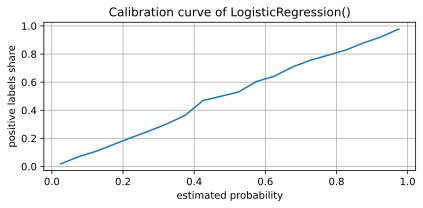

In [14]:
### your code here

_, _ = plot_calibration_curve(y_test, p1 ,'LogisticRegression()')

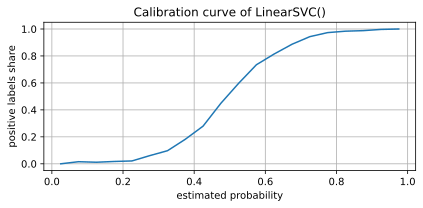

In [15]:
### your code here

_, _ = plot_calibration_curve(y_test,p2,'LinearSVC()')

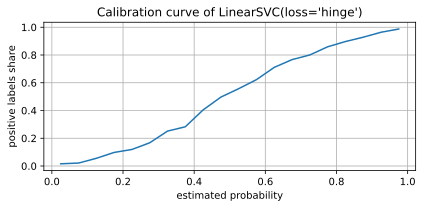

In [16]:
### your code here

_, _ = plot_calibration_curve(y_test,   p3,"LinearSVC(loss='hinge')")

<font color='brown'>**Exercise 9.** Analyze the distribution of classifiers' answers (build histograms using `plt.hist`). How do they differ? How can you explain this?</font>

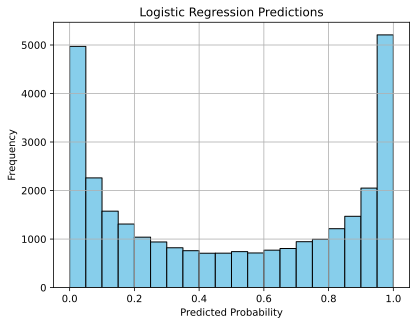

In [17]:
### your code here
### your code here
plt.hist(p1, bins=20, color='skyblue', edgecolor='black')
plt.title('Logistic Regression Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

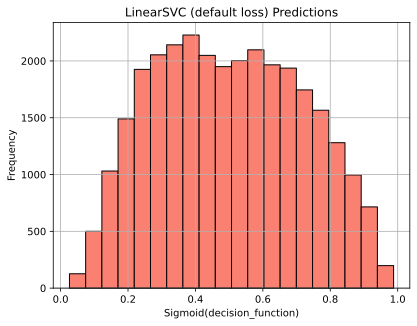

In [18]:
### your code here
plt.hist(p2, bins=20, color='salmon', edgecolor='black')
plt.title('LinearSVC (default loss) Predictions')
plt.xlabel('Sigmoid(decision_function)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

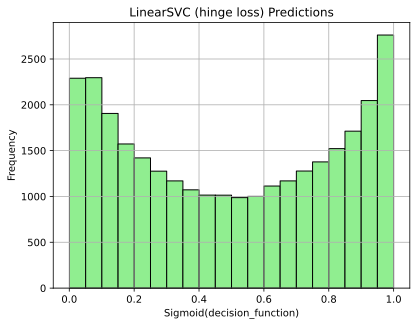

In [19]:
### your code here
plt.hist(p3, bins=20, color='lightgreen', edgecolor='black')
plt.title("LinearSVC (hinge loss) Predictions")
plt.xlabel('Sigmoid(decision_function)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

SVM optimizes the distance between classes, i.e. finds the separating hyperplane that is maximally distant from both classes. Logistic regression optimizes precisely the probabilities (the distance function after applying the sigmoid), so its calibration curve, which depends specifically on the probabilities, looks more plausible.

With SVM, as expected, after applying the sigmoid, we get a curve that resembles the sigmoid itself, which indicates that we have transformed a dependence close to linear. This linear relationship is the distance to the elements that is optimized in SVM.

<font color='brown'>**Exercise 10.** Use `CalibratedClassifierCV` from sklearn to calibrate SVM and use it to make predictions for the test set. Draw a calibration curve for them. Has it improved?</font>

In [20]:
### your code here
calibrated_svm = CalibratedClassifierCV(base_estimator=model1, method='sigmoid', cv=5)
calibrated_svm.fit(X_train, y_train)
probs_cal_svm = calibrated_svm.predict_proba(X_test)[:, 1]

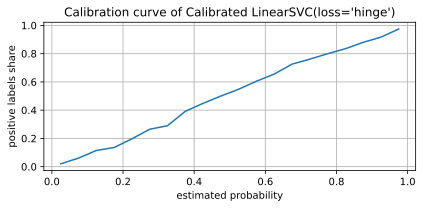

In [21]:
### your code here

_, _ = plot_calibration_curve(y_test, probs_cal_svm, "Calibrated LinearSVC(loss='hinge')")

In [22]:
### your code here
calibrated_default = CalibratedClassifierCV(base_estimator=model2, method='sigmoid',cv=5)
calibrated_default.fit(X_train, y_train)
probs_cal_default = calibrated_default.predict_proba(X_test)[:, 1]

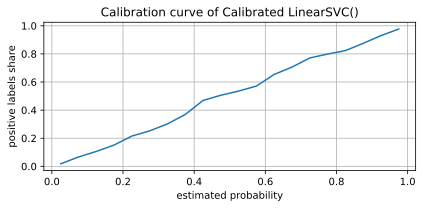

In [23]:
### your code here

_, _ = plot_calibration_curve(y_test, probs_cal_default, 'Calibrated LinearSVC()')

After calibration, the plot of the calibration curve became much closer to the diagonal, indicating that calibration made a significant contribution to the model's probability predictions.

## `Part 2. Logistic regression`

First we will try to train in logistic regression on the real data and evaluate classification quality.

__Data prepration__

Let's download data from the competition [Kaggle Porto Seguro's Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction). The objective is to identify drivers who will use their car insurance in the coming year (binary classification). But for us, it is not the task itself that will be important, but only its data. At the same time, we slightly modify the dataset to suit the needs of the task.

In [24]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Let's resample the data so that there are the same number of positive and negative objects in the data. Let's divide it into training and test samples:

In [25]:
# Some resampling:
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

<font color='brown'>**Exercise 11.** Train logistic regression with parameters you like. Make a prediction on the test part of the data:</font>

In [26]:
### your code here
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]

<font color='brown'>**Exercise 12.** Plot the ROC curve and calculate the ROC-AUC. What observations and conclusions can be drawn from them?</font>

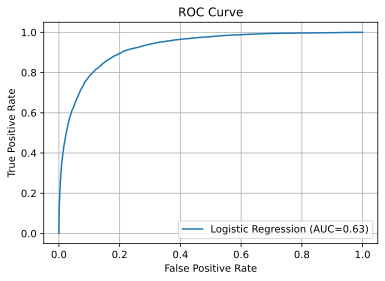

In [27]:
### your code here
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC={roc_auc_score(y_test, y_prob):.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

observations and conclusions

The ROC curve looks like a log shape that grows fast and then flattens out near 1. it stays within the normal range and doesn’t dip below zero, which is expected. Based on the shape, the model isn’t doing too bad, but it’s also not that great.the AUC is 0.63, so it"s better than random, but not super high. This means the model is somewhat able to separate the classes, but there’s still a lot of room to improve. Maybe with better features or some tuning, the performance could be better.



The model makes predictions only slightly better than constant ones (60% accuracy with 0.5 recall). This is most likely due to the fact that the data is not linearly separable.

<font color='brown'>**Exercise 13.** Check in practice how the regularizer affects the learning process (decrease in the loss function on the training and test data). To calculate the loss function on a test sample after each iteration, you can use the `warm_start` and `max_iter` parameters of `sklearn.linear_model.LogisticRegression` (use `solver='newton-cg'`):</font>

In [28]:
n_iter = 10
Cs = np.logspace(-3, 6, 10)
losses = np.zeros((len(Cs), 2, n_iter))

for al_idx, C in enumerate(Cs):
    ### your code here
     clf= LogisticRegression(penalty='l2',C=C,solver='newton-cg',warm_start=True, max_iter=1,random_state=42)

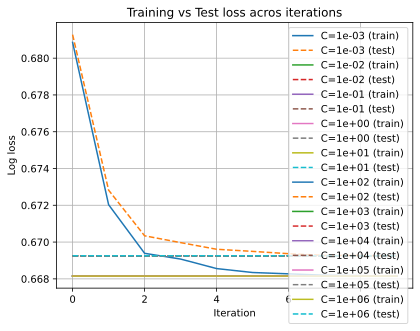

In [29]:
### your code here
for i, C in enumerate(Cs):
    for j in range(n_iter):
        clf.fit(X_train, y_train)
        probs_train = clf.predict_proba(X_train)[:,1]
        probs_test = clf.predict_proba(X_test)[:,1]
        losses[i, 0, j] = log_loss(y_train, probs_train)
        losses[i, 1, j] = log_loss(y_test, probs_test)
for i, C in enumerate(Cs):
    plt.plot(range(n_iter), losses[i, 0],label=f'C={C:.0e} (train)')
    plt.plot(range(n_iter), losses[i, 1], '--', label=f'C={C:.0e} (test)')
plt.xlabel('Iteration')
plt.ylabel('Log loss')
plt.title('Training vs Test loss acros iterations')
plt.legend()
plt.grid(True)
plt.show()

From the graphs it can be noted that as the regularization coefficient increases, our loss decreases, but at the same time the difference in loss on the train and on the test increases. Also, with an decrease in the regularization coefficient, the learning process accelerates.

## `Features selection`

An important part of the model building process is feature selection. In practice, many features have little impact on the model (and their calculation takes time) or even negatively affect the quality of the model. Let's try several approaches to feature selection, evaluate how they affect the quality of the model and how much time they take.

Let’s turn to the dataset about customer claims regarding insurance claims:

In [30]:
data = pd.read_csv('safe_driver_train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

As you remember, there are many categorical features in the data.

<font color='brown'>**Exercise 14.** Encode them using one-hot encoding. The original columns with categorical features can be deleted. How many features did we get? Use `ColumnTransformer` for encoding.</font>

In [31]:
enc_cols = ['bin' in col or 'cat' in col for col in X_train.columns]
np.sum(enc_cols)

31

In [33]:
### your code here

ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown='ignore',sparse_output=False), [col for col in X_train.columns if 'bin' in col or 'cat' in col])], remainder='passthrough')
X_train_enc = ct.fit_transform(X_train)
X_test_enc = ct.transform(X_test)
'Number of features: {}'.format(X_train_enc.shape[1])

'Number of features: 244'

In [34]:
assert X_train_enc.shape[1] == 244

We will use logistic regression as the main model, and ROC-AUC as the target metric.

<font color='brown'>**Exercise 15.** Train the model and calculate the quality on the test sample:</font>

In [35]:
### your code here
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_enc, y_train)
y_prob_test = logreg_model.predict_proba(X_test_enc)[:, 1]
print(roc_auc_score(y_test, y_prob_test))

0.638104334089478


### `Internal Methods`

Let's say we want to keep only the top 200 features. Let's try to do this in several ways.

Let's start with feature selection using a linear model. As is known, the weights of a linear model mean the contribution of each feature to the model’s prediction, which means that the modulus of this contribution can be interpreted as the importance of the features. This selection method is called internal or embedded methods, since it is embedded in the features of the model.

<font color='brown'>**Exercise 16.** Leave $200$ features with the largest modulus of the corresponding parameter of the linear model. Retrain the model and evaluate its quality. Has the quality changed? How?</font>

In [36]:
### your code here
feature_importance = np.abs(logreg_model.coef_[0])
X_train_top200 = X_train_enc[:, np.argsort(feature_importance)[-200:]]
X_test_top200 = X_test_enc[:, np.argsort(feature_importance)[-200:]]
logreg_top200 = LogisticRegression(max_iter=1000,random_state=42)
logreg_top200.fit(X_train_top200, y_train)
y_prob_top200 = logreg_top200.predict_proba(X_test_top200)[:, 1]

print(roc_auc_score(y_test, y_prob_top200))

0.6383604314781965


Quality has improved slightly.

Now let's think about what we didn't take into account. We assumed that the features contribute uniformly, but did not take into account their scale. If we multiply one of the features by $100$ times, then without taking into account regularization its weight will decrease by the same $100$ times. And we select features based on this!

<font color='brown'>**Exercise 17.** Let's first normalize the features in one of the ways, and only then remove the features. Use `ColumnTransformer`, `MinMaxScaler`, `Pipeline`. First train model on normalized features and measure its quality. Then remove unimportant features and retrain model.</font>

In [37]:
### your code here

pipeline = Pipeline([('scaler', ColumnTransformer([('minmax', MinMaxScaler(), slice(0, X_train_enc.shape[1]))])),('logreg', LogisticRegression(max_iter=1000, random_state=42))])

pipeline.fit(X_train_enc, y_train)
y_probas =pipeline.predict_proba(X_test_enc)[:, 1]
roc_auc_score(y_test, y_probas)

0.6380490118408293

In [38]:
### your code here

model = LogisticRegression()
model.fit(X_train_enc, y_train)
best_features = np.argsort(np.abs(model.coef_[0]))[-200:]
X_train_best=X_train_enc[:, best_features]
X_test_best= X_test_enc[:, best_features]
model.fit(X_train_best, y_train)
y_pred_best = model.predict_proba(X_test_best)[:, 1]
roc_auc_score(y_test, y_pred_best)

0.6383162507398776

On scaled data, the model trained worse before discarding features than on unscaled data. After discarding features, the quality of the model increased compared to the base model (without discarding features), but remained similar to the model' with randomly discarded features.

### `Filtering Methods`

Let's select features smarter, namely by calculating some function for each feature. Based on the values of this function, we will leave the most important features. Methods in this family are called filter methods.

We will consider t-statistics as such a function:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

where $\mu_{+/-}$, $\sigma_{+/-}$, $n_{+/-}$ accordingly is the average, standard deviation and the number of objects of each class.

<font color='brown'>**Exercise 18.** Leave 200 features with the highest value and measure the quality of the new model:</font>

In [39]:
def t_statistics(X, y):
    ### your code here
    if not hasattr(X, "power"):  # check if dense (no power method)
        from scipy import sparse
        X = sparse.csr_matrix(X)
    idx_pos = (y == 1).nonzero()[0]
    idx_neg = (y == 0).nonzero()[0]
    n_pos, n_neg = len(idx_pos), len(idx_neg)
    X_pos, X_neg = X[idx_pos], X[idx_neg]
    mu_pos, mu_neg = X_pos.mean(axis=0).A1, X_neg.mean(axis=0).A1
    var_pos = X_pos.power(2).mean(axis=0).A1 - mu_pos**2
    var_neg = X_neg.power(2).mean(axis=0).A1 - mu_neg**2
    numerator = np.abs(mu_pos - mu_neg)
    denominator = np.sqrt((n_pos*var_pos + n_neg*var_neg) / (n_pos + n_neg))
    denominator[denominator == 0] = 1e-10
    t = numerator / denominator
    return t

ts = t_statistics(X_train_enc, y_train)

In [40]:
import scipy as sp

gen = np.random.default_rng(seed=42)

ts_test = t_statistics(
    sp.sparse._csr.csr_matrix(gen.normal(size=(1000, 10))), gen.binomial(1, 0.5, size=(1000))
)
ts_test_true = [
    0.01601691, 0.11307686, 0.01932992, 0.0580195 , 0.05819344,
    0.06849519, 0.04136257, 0.03221009, 0.03528897, 0.10717818
]

assert np.allclose(ts_test, ts_test_true)

In [41]:
### your code here

model = LogisticRegression()

best_features = np.argsort(ts)[-200:]
X_train_top200 = X_train_enc[:, best_features]
X_test_top200 = X_test_enc[:, best_features]
model.fit(X_train_top200, y_train)
y_prob_top200 = model.predict_proba(X_test_top200)[:, 1]
roc_auc_score(y_test, y_prob_top200)

0.6389322554252589

### Wrapper methods


The final method we are considering works as follows: we exclude one of the features in turn and see how this affects the quality. We remove features in such a greedy way until we reach some criterion (the number of features or deterioration in quality).

Note that we cannot evaluate quality based on the test set, otherwise we may overtrain, as, for example, when tuning hyperparameters. Divide the sample into 2 parts, train a model without one of the features on one of them, and evaluate the quality on the second part. The original test sample should only be used for the final quality assessment.

To increase the performance of such algorithm let's take only a subset of our data to perform features selection:

In [42]:
smp_idxs = np.random.randint(0, y_train.shape[0], size=10000)
X_train_enc_smp, X_val_enc_smp, y_train_smp, y_val_smp = train_test_split(X_train_enc[smp_idxs], y_train[smp_idxs], test_size=0.1)

<font color='brown'>**Exercise 19.** Again, keep only $200$ features and evaluate the quality on a test sample::</font>

In [43]:
# Mask for best features. Initialize it with all features selected
best_features = np.ones(X_train_enc_smp.shape[1], dtype=np.bool8)
model = LogisticRegression(solver='newton-cholesky', n_jobs=-1)

while np.sum(best_features) > 200:
    best_score = 0
    discard_ftr_idx = -1
    # Traverse all features
    for ftr_idx in range(len(best_features)):
        # For each not removed feature try to remove it and measure score
        if not best_features[ftr_idx]:
            continue

        # Remove current feature
        best_features[ftr_idx] = False

        # Train the model and check its score without selected feature
        model.fit(X_train_enc_smp[:, best_features], y_train_smp)
        y_val_prob = model.predict_proba(X_val_enc_smp[:, best_features])[:, 1]
        score = roc_auc_score(y_val_smp, y_val_prob)

        # If current score larger than previous best update feature to remove
        if score > best_score:
            best_score = score
            discard_ftr_idx = ftr_idx

        # Return current feature to set
        best_features[ftr_idx] = True

    # Remove selected feature from features set
    best_features[discard_ftr_idx] = False

    print('Iteration ended, remaining features: {}, discarded features: {}, score: {}'.format(
        np.sum(best_features), np.sum(~best_features), best_score
    ))

Iteration ended, remaining features: 243, discarded features: 1, score: 0.5461201977938379
Iteration ended, remaining features: 242, discarded features: 2, score: 0.553347280334728
Iteration ended, remaining features: 241, discarded features: 3, score: 0.5601702168124763
Iteration ended, remaining features: 240, discarded features: 4, score: 0.5669931532902245
Iteration ended, remaining features: 239, discarded features: 5, score: 0.5732930772156714
Iteration ended, remaining features: 238, discarded features: 6, score: 0.579093761886649
Iteration ended, remaining features: 237, discarded features: 7, score: 0.5839672879421833
Iteration ended, remaining features: 236, discarded features: 8, score: 0.5889834537847091
Iteration ended, remaining features: 235, discarded features: 9, score: 0.5942373526055534
Iteration ended, remaining features: 234, discarded features: 10, score: 0.5988255990871054
Iteration ended, remaining features: 233, discarded features: 11, score: 0.6099990490680868

In [44]:
### your code here
model = LogisticRegression()
best_features = np.argsort(ts)[-200:]
model.fit(X_train_enc[:, best_features], y_train)
roc_auc_score(y_test, model.predict_proba(X_test_enc[:, best_features])[:, 1])

0.6389322554252589

Let's summarize the feature selection:

- Internal methods are the most intuitive method, and they work most transparently: if we remove a feature with a small weight, it cannot be
highly significant, since the linear model does not capture complex relationships between features, and the contribution of a feature is completely determined by its coefficient. This way we guarantee that the accuracy of predictions will not drop significantly when unimportant features are rejected. In general, l1 regularization does the same. \
The disadvantage of this method may be the mandatory scaling of the data, and the same scale for categorical and non-categorical values, which can be a non-trivial task.
- Filtering methods use more complex approaches that can provide better selection of features, but it is necessary to understand which filtering method is needed for selection in a given task.
- Wrapper methods - the method that works the longest, but is the most “accurate” method with a high-quality validation sample. However, due to its long operation on the entire sample, it is necessary to move to subsets of the sample, which makes this method unstable.

## The threshold for binarization of probabilities

In this part, we will perform standard operations to prepare the model for its real use - selecting a threshold for binarizing probabilities, taking into account the needs of a business or product. A good algorithm from the point of view of ROC-AUC is, of course, good, but in reality we need to make a binary decision, for example, whether to issue a loan to a person.

Let's use the same task as in the previous section — determining whether the client will contact the insurance company in the near future. The positive objects in our sample were those who applied to insurance clients.

Without going into the details of the insurance business, you can understand that a client’s claim regarding an insured event is unprofitable for us as an insurance company, because we lose money on this. Clients who do not contact the insurance company and drive carefully bring us money.

Suppose that for each client who contacted our insurance company, we lose $100000$, and for each client who did not contact the insurance company, we earn $5000$.

We will build an algorithm that predicts claims for an insured event, so that some potential clients will be denied service if we are sure that we will lose money on them.

In [46]:
data = pd.read_csv('safe_driver_train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

This time we will not sample the data and will use it "as is".

<font color='brown'>**Exercise 20.** Calculate the proportion of positive examples in the sample:</font>

In [47]:
### your code here
positive_ratio = np.mean(target)
positive_ratio

0.036447517859182946

Statistically, there are far fewer accidents than there are cars on the road. Therefore, it is logical to assume that not every person who insures their car expects to crash it. Therefore, the total share of insurance cases is small compared to the number of insurances.

<font color='brown'>**Exercise 21.** As you remember, there are many categorical features in the data. Let's encode them using one-hot encoding. The original columns with categorical features can be deleted.</font>

In [48]:
### your code here

ct = ColumnTransformer(transformers=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False),[col for col in X_train.columns if 'bin' in col or 'cat' in col])],remainder='drop'  )
X_train_enc = ct.fit_transform(X_train)
X_test_enc = ct.transform(X_test)

<font color='brown'>**Exercise 22.** Our main model will be logistic regression, which returns the probability of a positive class. Train the model, make predictions on the test set:</font>

In [49]:
### your code here
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_enc, y_train)
probs = clf.predict_proba(X_test_enc)[:, 1]

<font color='brown'>**Exercise 23.** Calculate ROC-AUC and accuracy:</font>

In [50]:
### your code here
from sklearn.metrics import accuracy_score
y_pred = (probs >= 0.5).astype(int)
print((roc_auc_score(y_test, probs), accuracy_score(y_test, y_pred)))

(0.6215260773881041, 0.9635677864301135)


We are solving a problem with strong class imbalance. Therefore, the model is trained to make almost constant predictions, biased towards the larger class. If we look at accuracy (model.score), we will see that everything seems to be good. Accuracy estimates the number of correctly classified objects, and this metric does not care that one class may be classified perfectly and another may not be classified at all.

But ROC-AUC is a metric that does not depend on class imbalance, so it produces a poor result if one of the classes is predicted much worse than the other.

We have an algorithm that determines the likelihood of a client filing an insurance claim, but we want to use this algorithm to deny clients service from the insurance company. To do this, we need the binary predictions of the algorithm. Let's look for this threshold to obtain binary predictions.


Sometimes it is difficult to decide what values of precision and recall are needed in our task. However, sometimes it is possible to estimate the economic impact of our algorithm. We know how much a client who contacts an insurance company costs us, and how much a client who does not contact us brings us.

With a fixed threshold, we know who we would refuse service to. Among them there are those who would contact the insurance company and we would have to spend money, and those who would not apply, that is, they would bring us money. We can calculate the difference between our income and expenses from this group of people and hope that it will be positive.

<font color='brown'>**Exercise 24.** Find a threshold at which our balance (the difference between income and expenses on the group of clients we rejected) is non-negative. Income, obviously, is calculated only for those people whom we assume were not rejected.</font>

In [164]:
def profit_score(y_true, y_preds):
    loss_per_tn, gain_per_fp = 100000, 5000
    ### your code here
    
    profit =np.sum((y_preds == 0) & (y_true == 0)) * gain_per_fp
    loss = np.sum((y_preds == 0) & (y_true == 1)) * loss_per_tn + np.sum((y_preds == 1) & (y_true == 0)) * gain_per_fp
   
    return profit - loss

In [165]:
gen = np.random.default_rng(seed=42)

assert profit_score(gen.binomial(1, 0.5, size=1000), gen.binomial(1, 0.5, size=1000)) == -25405000

In [166]:
def plot_profit_threshold_curve(y_test, y_probas, precision=10**4, show=True):
    profits, thresholds = [], np.linspace(0.0, 1.0, precision)
    for threshold in tqdm(thresholds):
        ### your code here
        y_preds = (y_probas >=threshold).astype(int)
        profits.append(profit_score(y_test, y_preds))
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.plot(thresholds, profits)
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Profit')
        ax.set_title('Dependence of profit on threshold')
        ax.grid(True)

        fig.tight_layout()
        plt.show()

    return thresholds, profits

In [167]:
gen = np.random.default_rng(seed=42)

thresholds, profits = plot_profit_threshold_curve(
    gen.binomial(1, 0.5, size=1000), np.abs(gen.normal(size=1000)), precision=11, show=False
)

thresholds_true = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
profits_true = [
    -2515000, -5675000, -8995000, -12895000, -16195000, -19815000,
    -23305000, -26325000, -29185000, -31495000, -33445000
]

assert np.allclose(profits_true, profits)
assert np.allclose(thresholds_true, thresholds)

100%|██████████| 11/11 [00:00<00:00, 5503.02it/s]


100%|██████████| 10000/10000 [00:12<00:00, 819.05it/s]


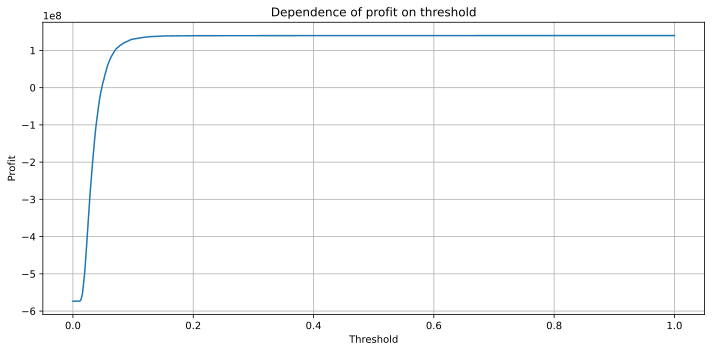

In [168]:
### your code here

thresholds, profits = plot_profit_threshold_curve(y_test, y_probas)

In [169]:
### your code here

'profit > 0 starting at threshold {}, profit = {}'.format(thresholds[np.argmax(np.array(profits) > 0)], profits[np.argmax(np.array(profits) > 0)])

'profit > 0 starting at threshold 0.04810481048104811, profit = 820000'

<font color='brown'>**Exercise 25.** And at what threshold value is this difference maximum? How many customers have we denied service to?</font>

In [170]:
### your code here

best_thresh = thresholds[np.argmax(profits)]
best_profit = profits[np.argmax(profits)]
refusal_count = np.sum(y_probas >= best_thresh)



'Best threshold: {}, profit: {}, refusal count: {}'.format(
     best_thresh, best_profit, refusal_count
)

'Best threshold: 0.5093509350935094, profit: 139830000, refusal count: 0'

**Rules:**

* The use of AI and any other violations mentioned in the Academic Integrity Policy is strictly prohibited. For more information, please refer to the Academic Integrity Policy of Constructor University: https://constructor.university/sites/default/files/2024-09/CAI%202024%20vf.pdf If a student's work violates these rules, the work will be disregarded, no points will be awarded, and the Academic Integrity team may be notified.

* Students are not allowed to copy and paste examples described in the lab if the example contains several lines of code and implements a non-trivial idea. Please write the code on your own. Violations of this rule will result in point deductions. Even for theoretical answers, copying and pasting will not be tolerated; please use your own words to enhance your critical thinking.

* Late submissions will not be accepted. Even if a few seconds late, work submitted after the given deadline will not be graded. Additionally, any work that has been uploaded but not formally submitted will be disregarded. If you experience technical issues, you may submit your homework via email, but not after the given deadline.